# Making Transformers Efficient

In [1]:
import pathlib
from time import perf_counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from torch.quantization import quantize_dynamic
import torch.nn as nn
import torch.nn.functional as F

import optuna
from datasets import load_metric, load_dataset
from transformers import (
    pipeline, TrainingArguments, Trainer, AutoTokenizer, AutoConfig,
    AutoModelForSequenceClassification
)
from huggingface_hub import notebook_login

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
import pickle

def dump_metrics(metrics):
    with open('performance-metrics.p', 'wb') as fp:
        pickle.dump(metrics, fp)
        

def load_metrics(file='performance-metrics.p'):
    with open(file, 'rb') as fp:
        return pickle.load(fp)

In [4]:
try:
    perf = load_metrics()
except FileNotFoundError:
    pass

In [5]:
notebook_login()

In [6]:
ckpt = 'transformersbook/bert-base-uncased-finetuned-clinc'
pipe = pipeline('text-classification', model=ckpt)

Downloading:   0%|          | 0.00/7.98k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [7]:
query = "I'd like to rent a vehicle in Parise and I need a 15 passenger van"
pipe(query)

[{'label': 'car_rental', 'score': 0.5302357077598572}]

In [8]:
data = load_dataset('clinc_oos', 'plus')
data['test'][42]

Generating train split:   0%|          | 0/15250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5500 [00:00<?, ? examples/s]

Dataset clinc_oos downloaded and prepared to /root/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [9]:
intents = data['test'].features['intent']
get_intents = lambda x: intents.str2int(x)  # mapper func

In [10]:
intents.int2str(data['test'][42]['intent'])

'transfer'

<hr>

## Baseline Benchmark

In [11]:
class PerformanceBenchmark:

    def __init__(self, pipeline, dataset, optim_type='BERT baseline'):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type
        self.score = load_metric('accuracy')

    def compute_accuracy(self, mapper):
        preds, labels = [], []
        for example in tqdm(self.dataset):
            pred = self.pipeline(example['text'])[0]['label']
            label = example['intent']
            if mapper:
                preds.append(mapper(pred))
            else:
                preds.append(pred)
            labels.append(label)
        results = self.score.compute(predictions=preds, references=labels)
        print(f'Accuracy on test set: {results["accuracy"]:.3f}')
        return results

    def compute_size(self):
        state = self.pipeline.model.state_dict()
        fp = pathlib.Path('model.pt')
        torch.save(state, fp)
        mb = pathlib.Path(fp).stat().st_size / (1024**2)
        fp.unlink(missing_ok=True)
        print(f'Model size (MB): {mb:.2f}')
        return {'size_mb': mb}

    def time_pipeline(self, query='What is the pin number for my account?'):
        latencies = []
        for _ in range(100):
            start = perf_counter()
            _ = self.pipeline(query)
            latencies.append(perf_counter() - start)
        avg_ms = np.mean(latencies) * 1000
        std_ms = np.std(latencies) * 1000
        print(f'Average latency (ms): {avg_ms:.2f} +/- {std_ms:.2f}')
        return {'avg_ms': avg_ms, 'std_ms': std_ms}

    def run(self, query=None, mapper=None):
        if query is None:
            query='What is the pin number for my account?'
        metrics = {
            self.optim_type: self.compute_size()
        }
        metrics[self.optim_type].update(self.time_pipeline(query))
        metrics[self.optim_type].update(self.compute_accuracy(mapper))
        return metrics

In [9]:
pb = PerformanceBenchmark(pipe, data['test'])
perf = pb.run(mapper=get_intents)

Model size (MB): 418.16
Average latency (ms): 51.95 +/- 37.02


100%|██████████| 5500/5500 [05:02<00:00, 18.18it/s]

Accuracy on test set: 0.867


## Knowledge Distillation

In [12]:
class DistillationTrainArgs(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temp=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temp = temp

In [13]:
class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher = teacher
        self.loss_func = nn.KLDivLoss(reduction='batchmean')
        
    def calc_loss(self, model, inputs, return_outputs=False):
        student_out = model(**inputs)
        student_logits = student_out.logits
        loss_ce = student_out.loss
        
        with torch.no_grad():
            teacher_out = self.teacher(**inputs)
            teacher_logits = teacher_out.logits
        
        loss_kd = self.args.temp ** 2 * self.loss_func(
            F.log_softmax(student_logits / self.args.temp, dim=-1),
            F.softmax(teacher_logits / self.args.temp, dim=-1)
        )
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, student_out) if return_outputs else loss
        

In [14]:
student_ckpt = 'distilbert-base-uncased'
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [15]:
def tokenize_text(batch):
    return student_tokenizer(batch['text'], truncation=True)

In [16]:
data_enc = data.map(tokenize_text, batched=True, remove_columns=['text'])
data_enc = data_enc.rename_column('intent', 'labels')

Parameter 'function'=<function tokenize_text at 0x7f60750f7940> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [17]:
data_enc['train'][0]

{'labels': 61,
 'input_ids': [101,
  2054,
  3670,
  2052,
  1045,
  2224,
  2000,
  2360,
  1045,
  2293,
  2017,
  2065,
  1045,
  2020,
  2019,
  3059,
  102],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [18]:
def get_metrics(outputs):
    metric = load_metric('accuracy')
    preds, labels = outputs
    preds = np.argmax(preds, axis=1)
    return metric.compute(predictions=preds, references=labels)

In [19]:
bs = 48
ft_ckpt = 'distilbert-base-uncased-finetuned-clinc'

train_args = DistillationTrainArgs(
    output_dir=ft_ckpt,
    evaluation_strategy='epoch',
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs,
    alpha=1,
    weight_decay=0.01,
    push_to_hub=True
)

In [20]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [21]:
num_labels = intents.num_classes

In [22]:
student_config = AutoConfig.from_pretrained(
    student_ckpt,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

In [23]:
def student_init():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    return AutoModelForSequenceClassification.from_pretrained(student_ckpt, config=student_config).to(device)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = AutoModelForSequenceClassification.from_pretrained(teacher_ckpt, num_labels=num_labels).to(device)

In [26]:
distilbert_trainer = DistillationTrainer(
    model_init=student_init,
    teacher=teacher_model,
    args=train_args,
    train_dataset=data_enc['train'],
    eval_dataset=data_enc['validation'],
    compute_metrics=get_metrics,
    tokenizer=student_tokenizer
)

https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp7n_fk_qb


Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
creating metadata file for /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias

In [ ]:
distilbert_trainer.train()

In [ ]:
distilbert_trainer.push_to_hub('training complete')

In [27]:
ft_ckpt = 'chris-santiago/distilbert-base-uncased-finetuned-clinc'
pipe = pipeline('text-classification', ft_ckpt)

https://huggingface.co/chris-santiago/distilbert-base-uncased-finetuned-clinc/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp90b4kl6m


Downloading:   0%|          | 0.00/8.01k [00:00<?, ?B/s]

storing https://huggingface.co/chris-santiago/distilbert-base-uncased-finetuned-clinc/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/94081c597927333eeebc0263815e9596474466a3f93ea7a7708e37c166793b59.e498684d4c1b0b030c3a11d06b8ba4e6e182cb76f073c64455f6f656e5985942
creating metadata file for /root/.cache/huggingface/transformers/94081c597927333eeebc0263815e9596474466a3f93ea7a7708e37c166793b59.e498684d4c1b0b030c3a11d06b8ba4e6e182cb76f073c64455f6f656e5985942
loading configuration file https://huggingface.co/chris-santiago/distilbert-base-uncased-finetuned-clinc/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/94081c597927333eeebc0263815e9596474466a3f93ea7a7708e37c166793b59.e498684d4c1b0b030c3a11d06b8ba4e6e182cb76f073c64455f6f656e5985942
Model config DistilBertConfig {
  "_name_or_path": "chris-santiago/distilbert-base-uncased-finetuned-clinc",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
 

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

storing https://huggingface.co/chris-santiago/distilbert-base-uncased-finetuned-clinc/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/09c297ae1dacbf810acfb54fd7579b916708c587bb4991cc10ce2b7f1ae8bd4d.7465c71dc121dfa5a70bf35bc84e22058a918747e00ecfff88c834491645e028
creating metadata file for /root/.cache/huggingface/transformers/09c297ae1dacbf810acfb54fd7579b916708c587bb4991cc10ce2b7f1ae8bd4d.7465c71dc121dfa5a70bf35bc84e22058a918747e00ecfff88c834491645e028
loading weights file https://huggingface.co/chris-santiago/distilbert-base-uncased-finetuned-clinc/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/09c297ae1dacbf810acfb54fd7579b916708c587bb4991cc10ce2b7f1ae8bd4d.7465c71dc121dfa5a70bf35bc84e22058a918747e00ecfff88c834491645e028
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at 

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

storing https://huggingface.co/chris-santiago/distilbert-base-uncased-finetuned-clinc/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/7f415105a854b874257ea9b1fd70e59180db7f85d8053ef83dc36318c586dc75.42154c5fd30bfa7e34941d0d8ad26f8a3936990926fbe06b2da76dd749b1c6d4
creating metadata file for /root/.cache/huggingface/transformers/7f415105a854b874257ea9b1fd70e59180db7f85d8053ef83dc36318c586dc75.42154c5fd30bfa7e34941d0d8ad26f8a3936990926fbe06b2da76dd749b1c6d4
https://huggingface.co/chris-santiago/distilbert-base-uncased-finetuned-clinc/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpyqbgfkot


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

storing https://huggingface.co/chris-santiago/distilbert-base-uncased-finetuned-clinc/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/5de4c70a1c83a67bb6b58fbea22023e464667d1d84f6020e9bfd967725cff29d.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
creating metadata file for /root/.cache/huggingface/transformers/5de4c70a1c83a67bb6b58fbea22023e464667d1d84f6020e9bfd967725cff29d.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
https://huggingface.co/chris-santiago/distilbert-base-uncased-finetuned-clinc/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpjc56qzur


Downloading:   0%|          | 0.00/695k [00:00<?, ?B/s]

storing https://huggingface.co/chris-santiago/distilbert-base-uncased-finetuned-clinc/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/afac070e3e11afb02fb532253b2fe03107b96fd5b80528be2607697592472a61.848c414913cfee271695b8761d3e947fb18a724fbad549de63228b20e5f2d615
creating metadata file for /root/.cache/huggingface/transformers/afac070e3e11afb02fb532253b2fe03107b96fd5b80528be2607697592472a61.848c414913cfee271695b8761d3e947fb18a724fbad549de63228b20e5f2d615
https://huggingface.co/chris-santiago/distilbert-base-uncased-finetuned-clinc/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpea_8yhax


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

storing https://huggingface.co/chris-santiago/distilbert-base-uncased-finetuned-clinc/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/65e5a540e3895c2d8f7e12963dbe58cb42db0cd3df461263ffb6728337b64de8.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
creating metadata file for /root/.cache/huggingface/transformers/65e5a540e3895c2d8f7e12963dbe58cb42db0cd3df461263ffb6728337b64de8.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/chris-santiago/distilbert-base-uncased-finetuned-clinc/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/5de4c70a1c83a67bb6b58fbea22023e464667d1d84f6020e9bfd967725cff29d.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/chris-santiago/distilbert-base-uncased-finetuned-clinc/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/afac070e3e11afb02fb532253b2fe03107b

In [29]:
optim_type = 'DistilBERT'
pb = PerformanceBenchmark(pipe, data['test'], optim_type=optim_type)
perf.update(pb.run(mapper=get_intents))

Model size (MB): 255.89
Average latency (ms): 33.89 +/- 31.08


100%|██████████| 5500/5500 [02:38<00:00, 34.62it/s]

Accuracy on test set: 0.862


In [28]:
perf

{'BERT baseline': {'size_mb': 418.1629457473755,
  'avg_ms': 51.94768721237779,
  'std_ms': 37.02247969711823,
  'accuracy': 0.8672727272727273},
 'DistilBERT': {'size_mb': 255.887375831604,
  'avg_ms': 33.894889783114195,
  'std_ms': 31.0773435447728,
  'accuracy': 0.8623636363636363}}

In [37]:
dump_metrics(perf)

In [29]:
def plot_metrics(perf_metrics, curr_optim):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')
    
    for idx in df.index:
        df_opt = df.loc[idx]
        if idx == curr_optim:
            plt.scatter(
                df_opt['avg_ms'], df_opt['accuracy'] * 100, alpha=0.5, s=df_opt['size_mb'], label=idx, marker='$\u25CC$'
            )
        else:
            plt.scatter(
                df_opt['avg_ms'], df_opt['accuracy'] * 100, alpha=0.5, s=df_opt['size_mb'], label=idx
            )
        
    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])
        
    plt.ylim(80, 90)
    xlim = int(perf['BERT baseline']['avg_ms'] + 3)
    plt.xlim(1, xlim)
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Average Latency (ms)')
    plt.show()

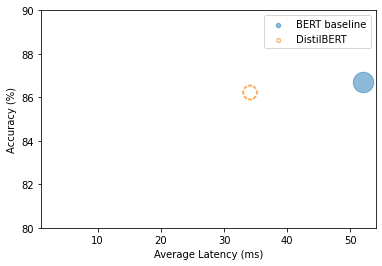

In [30]:
plot_metrics(perf, 'DistilBERT')


## Tuning with Optuna

In [31]:
def hp_space(trial):
    return {
        'num_train_epochs': trial.suggest_int('num_train_epochs', 5, 10),
        'alpha': trial.suggest_float('alpha', 0, 1),
        'temp': trial.suggest_int('temp', 2, 20)
    }

In [32]:
best_run = distilbert_trainer.hyperparameter_search(
    n_trials=5,
    direction='maximize',
    hp_space=hp_space
)

[I 2022-08-24 00:13:35,424] A new study created in memory with name: no-name-8350eea5-f21b-4c1b-80c4-24889c5fc7da
Trial:
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertF

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.266096,0.738387
2,3.771200,1.857105,0.830968
3,3.771200,1.152443,0.891935
4,1.677000,0.855964,0.912258
5,0.899600,0.773910,0.915161


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48


Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-0/

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.162158,0.746774
2,3.691800,1.555480,0.856452
3,3.691800,0.772798,0.914194
4,1.325700,0.458926,0.931935
5,0.431000,0.335022,0.942581
6,0.431000,0.287883,0.940645
7,0.175200,0.260885,0.946452
8,0.089300,0.251202,0.945484
9,0.089300,0.248783,0.945161
10,0.062000,0.246867,0.945806


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-100

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.171567,0.747097
2,3.699000,1.586268,0.855484
3,3.699000,0.805687,0.911935
4,1.359300,0.485805,0.930000
5,0.464600,0.356274,0.939355
6,0.464600,0.303909,0.939032
7,0.202500,0.274777,0.943871
8,0.113100,0.264460,0.942258
9,0.113100,0.261513,0.944516


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-100

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.188062,0.744194
2,3.711300,1.628678,0.852258
3,3.711300,0.851679,0.909355
4,1.406800,0.524400,0.928065
5,0.513900,0.388492,0.935806
6,0.513900,0.331550,0.938387
7,0.245600,0.302341,0.940000
8,0.157700,0.296364,0.940323


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-100

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.204882,0.744516
2,3.724200,1.677219,0.848065
3,3.724200,0.910575,0.905806
4,1.462600,0.580860,0.923548
5,0.582100,0.441618,0.933871
6,0.582100,0.383674,0.935161
7,0.317000,0.365522,0.936774


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-100

In [33]:
print(best_run)

BestRun(run_id='1', objective=0.9458064516129032, hyperparameters={'num_train_epochs': 10, 'alpha': 0.1284172471968621, 'temp': 14})


In [34]:
for k, v in best_run.hyperparameters.items():
    setattr(train_args, k, v)
    
distilled_ckpt = 'distilbert-base-uncased-distilled-clinc'
train_args.output_dir = distilled_ckpt

In [35]:
distill_trainer = DistillationTrainer(
    model_init=student_init,
    teacher=teacher_model,
    args=train_args,
    train_dataset=data_enc['train'],
    eval_dataset=data_enc['validation'],
    compute_metrics=get_metrics,
    tokenizer=student_tokenizer
)

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSe

In [36]:
distill_trainer.train()

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSe

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.162158,0.746774
2,3.691800,1.555480,0.856452
3,3.691800,0.772798,0.914194
4,1.325700,0.458926,0.931935
5,0.431000,0.335022,0.942581
6,0.431000,0.287883,0.940645
7,0.175200,0.260885,0.946452
8,0.089300,0.251202,0.945484
9,0.089300,0.248783,0.945161
10,0.062000,0.246867,0.945806


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-distilled-clinc/checkpoint-500
Configuration saved in distilbert-base-uncased-distilled-clinc/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-distilled-clinc/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-distilled-clinc/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-distilled-clinc/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-distilled-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-distilled-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-distilled-clinc/checkpoint-1000
Configuration saved in distilbert-

TrainOutput(global_step=3180, training_loss=0.9111540221568174, metrics={'train_runtime': 531.7474, 'train_samples_per_second': 286.79, 'train_steps_per_second': 5.98, 'total_flos': 827475185485200.0, 'train_loss': 0.9111540221568174, 'epoch': 10.0})

In [37]:
distill_trainer.push_to_hub('training complete')

Saving model checkpoint to distilbert-base-uncased-distilled-clinc
Configuration saved in distilbert-base-uncased-distilled-clinc/config.json
Model weights saved in distilbert-base-uncased-distilled-clinc/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-distilled-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-distilled-clinc/special_tokens_map.json


Upload file pytorch_model.bin:   0%|          | 32.0k/256M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/chris-santiago/distilbert-base-uncased-distilled-clinc
   9d24c9f..0089198  main -> main

To https://huggingface.co/chris-santiago/distilbert-base-uncased-distilled-clinc
   0089198..634c764  main -> main



'https://huggingface.co/chris-santiago/distilbert-base-uncased-distilled-clinc/commit/00891981919692b4398c3ace2430fe4fd1159705'

In [40]:
distilled_ckpt = 'chris-santiago/distilbert-base-uncased-distilled-clinc'
pipe = pipeline('text-classification', distilled_ckpt)
optim_type = 'Distillation'

pb = PerformanceBenchmark(pipe, data['test'], optim_type=optim_type)
perf.update(pb.run(mapper=get_intents))

loading configuration file https://huggingface.co/chris-santiago/distilbert-base-uncased-distilled-clinc/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a9219eab0d3dd0b4c119718141ce65e554a271f9ad4b28a3ae4148569d20b305.e498684d4c1b0b030c3a11d06b8ba4e6e182cb76f073c64455f6f656e5985942
Model config DistilBertConfig {
  "_name_or_path": "chris-santiago/distilbert-base-uncased-distilled-clinc",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "restaurant_reviews",
    "1": "nutrition_info",
    "2": "account_blocked",
    "3": "oil_change_how",
    "4": "time",
    "5": "weather",
    "6": "redeem_rewards",
    "7": "interest_rate",
    "8": "gas_type",
    "9": "accept_reservations",
    "10": "smart_home",
    "11": "user_name",
    "12": "report_lost_card",
    "13": "repeat",
    "14": "whisper_mode",
    "15": 

Model size (MB): 255.89
Average latency (ms): 42.13 +/- 29.71


100%|██████████| 5500/5500 [04:15<00:00, 21.49it/s]

Accuracy on test set: 0.889


In [41]:
perf

{'BERT baseline': {'size_mb': 418.1629457473755,
  'avg_ms': 51.94768721237779,
  'std_ms': 37.02247969711823,
  'accuracy': 0.8672727272727273},
 'DistilBERT': {'size_mb': 255.887375831604,
  'avg_ms': 33.894889783114195,
  'std_ms': 31.0773435447728,
  'accuracy': 0.8623636363636363},
 'Distillation': {'size_mb': 255.887375831604,
  'avg_ms': 42.12866319343448,
  'std_ms': 29.7106176489378,
  'accuracy': 0.8894545454545455}}

In [42]:
dump_metrics(perf)

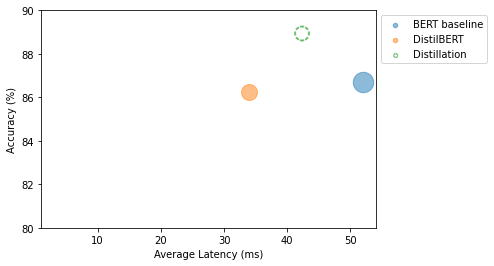

In [43]:
plot_metrics(perf, optim_type)

## Quantization

In [44]:
tokenizer = AutoTokenizer.from_pretrained(distilled_ckpt)
model = AutoModelForSequenceClassification.from_pretrained(distilled_ckpt).to('cpu')
model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

loading file https://huggingface.co/chris-santiago/distilbert-base-uncased-distilled-clinc/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/8c69bc7b4d921cd3e252a9822e17335573af316c526e2d2152260edd6a498034.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/chris-santiago/distilbert-base-uncased-distilled-clinc/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/dc5a26f5c4f04a2cdf6ca19f7c8bb7fd5ea90e04ebc548627153e411c44651f1.848c414913cfee271695b8761d3e947fb18a724fbad549de63228b20e5f2d615
loading file https://huggingface.co/chris-santiago/distilbert-base-uncased-distilled-clinc/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/chris-santiago/distilbert-base-uncased-distilled-clinc/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/2c636309b0c12500aefb067bef50ae4d38c08d5db8a70f5844ca2eae2674473e.dd8bd9bfd3664b530

In [47]:
pipe = pipeline('text-classification', model=model_quantized, tokenizer=tokenizer)
optim_type = 'Distillation+Quantization'

pb = PerformanceBenchmark(pipe, data['test'], optim_type=optim_type)
perf.update(pb.run(mapper=get_intents))

Model size (MB): 132.40
Average latency (ms): 28.43 +/- 17.83


100%|██████████| 5500/5500 [03:12<00:00, 28.54it/s]


Accuracy on test set: 0.895


In [48]:
perf

{'BERT baseline': {'size_mb': 418.1629457473755,
  'avg_ms': 51.94768721237779,
  'std_ms': 37.02247969711823,
  'accuracy': 0.8672727272727273},
 'DistilBERT': {'size_mb': 255.887375831604,
  'avg_ms': 33.894889783114195,
  'std_ms': 31.0773435447728,
  'accuracy': 0.8623636363636363},
 'Distillation': {'size_mb': 255.887375831604,
  'avg_ms': 42.12866319343448,
  'std_ms': 29.7106176489378,
  'accuracy': 0.8894545454545455},
 'Distillation+Quantization': {'size_mb': 132.3969964981079,
  'avg_ms': 28.426045808009803,
  'std_ms': 17.831509069216693,
  'accuracy': 0.8954545454545455}}

In [49]:
dump_metrics(perf)

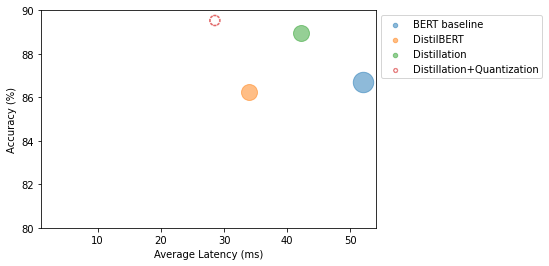

In [50]:
plot_metrics(perf, optim_type)